In [4]:
import requests 
import numpy as np
import pandas as pd
from datetime import datetime
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
#These points should be working but they are not
#g  ='{"type":"Polygon","coordinates":[[[-122.0625 38.0625], [-121.0625 38.0625],[-121.0625 38.5625],[-122.0625 38.5625],[-122.0625 38.0625]]]}'

In [6]:
g = 'POLYGON ((-122.0625 38.0625, -121.0625 38.0625, -121.0625 38.5625, -122.0625 38.5625, -122.0625 38.0625))'
#code run without error with below polygon
params = {'g': g, 'stat': 'mean'}

In [7]:
# Cal-Adapt API
api = 'http://api.cal-adapt.org/api'

# Request header
headers = {'ContentType': 'json'}

def process_daily_data(slug, params):
    # Make request
    url = api + '/series/' + slug + '/rasters/'
    response = requests.get(url, params=params)
    
    # Get data
    if response.ok:
        #print('Processing:', slug)
        json = response.json()
        data = json['results'][0]
        # Multiband raster data is returned by the API as a 3D array having a shape like (233376, 1, 1)
        # Flatten the 3D array into a 1D array
        values_arr = np.array(data['image'])
        values_arr = values_arr.flatten()# Get total number of values -> number of days
        length = len(values_arr)
        # Get start date of timeseries
        start_date = datetime.strptime(data['event'], '%Y-%m-%d')
        
        # Create new pandas dataframe and map each value in list to a date index
        df = pd.DataFrame(
            values_arr,
            index= pd.date_range(start_date, freq='1D', periods=length),
            columns=['value']
        )    
        
        # Add slug as a column
        df['slug'] = slug  

    else:
        print('Failed to download:', slug)
            
    # Combine all the dataframes into one and return
    return df

In [11]:
def get_projections():
    # Create an empty list to hold dataframes
    df_list = []

    # Make a combined list of GCMs, scenarios, climate variables for looping
    climvar = ['pr']
    period = ['day']
    models = ['CanESM2', 'CNRM-CM5', 'HadGEM2-ES', 'MIROC5', 'ACCESS1-0']
    scenarios = ['historical','rcp85']
    zipped = itertools.product(climvar, period, models, scenarios)
    print(zipped)
    # Request parameters
  
    # Loop through zipped
    for item in zipped:
        # Create slug
        slug = '_'.join(item)
        df = process_daily_data(slug, params)
        df_list.append(df)
            
    # Combine all the dataframes into one and return
    return pd.concat(df_list)

In [12]:
projectedDF = get_projections()
projectedDF.head(10)


,value,slug
1950-01-01,2.365591e-04,pr_day_CanESM2_historical
1950-01-02,9.486181e-05,pr_day_CanESM2_historical
1950-01-03,1.569224e-05,pr_day_CanESM2_historical
1950-01-04,5.282777e-05,pr_day_CanESM2_historical
1950-01-05,1.384846e-05,pr_day_CanESM2_historical
1950-01-06,3.914579e-07,pr_day_CanESM2_historical
1950-01-07,2.182621e-08,pr_day_CanESM2_historical
1950-01-08,1.603315e-07,pr_day_CanESM2_historical
1950-01-09,1.676218e-06,pr_day_CanESM2_historical
1950-01-10,3.713039e-06,pr_day_CanESM2_historical


In [13]:
projectedDF.tail(10)

,value,slug
2100-12-22,2.714491e-06,pr_day_ACCESS1-0_rcp85
2100-12-23,1.681353e-05,pr_day_ACCESS1-0_rcp85
2100-12-24,7.691494e-06,pr_day_ACCESS1-0_rcp85
2100-12-25,4.456464e-06,pr_day_ACCESS1-0_rcp85
2100-12-26,2.389211e-05,pr_day_ACCESS1-0_rcp85
2100-12-27,1.193507e-06,pr_day_ACCESS1-0_rcp85
2100-12-28,2.046991e-05,pr_day_ACCESS1-0_rcp85
2100-12-29,3.256932e-05,pr_day_ACCESS1-0_rcp85
2100-12-30,0.000000e+00,pr_day_ACCESS1-0_rcp85
2100-12-31,1.220502e-07,pr_day_ACCESS1-0_rcp85


In [14]:
temp = projectedDF['slug'].str.split('_', expand=True)[2]
projectedDF['test'] = temp

In [15]:
projectedDF.drop(columns= 'slug', inplace = True)
projectedDF.head()

,value,test
1950-01-01,0.000237,CanESM2
1950-01-02,0.000095,CanESM2
1950-01-03,0.000016,CanESM2
1950-01-04,0.000053,CanESM2
1950-01-05,0.000014,CanESM2


In [10]:
projectedDF.index.name = 'Date'

In [11]:
projectedDF = projectedDF.pivot_table( values = 'value', index = 'Date', columns = 'test')
projectedDF.tail()

test,ACCESS1-0,CNRM-CM5,CanESM2,HadGEM2-ES,MIROC5
Date,,,,,
2100-12-27,1.193507e-06,0.000000e+00,0.000013,NaN,NaN
2100-12-28,2.046991e-05,2.469138e-08,0.000007,NaN,NaN
2100-12-29,3.256932e-05,0.000000e+00,0.000029,NaN,NaN
2100-12-30,0.000000e+00,1.892917e-05,0.000052,NaN,NaN
2100-12-31,1.220502e-07,5.725396e-06,0.000108,NaN,NaN


In [12]:
#projectedDF[] = projectedDF.iloc[0:4].apply(lambda x: x * 86400)
projectedDF = projectedDF.apply(lambda x: x*86400)

In [13]:
projectedDF.loc['2020-12-05': '2020-12-31', :]
#projectedDF.tail(40)


test,ACCESS1-0,CNRM-CM5,CanESM2,HadGEM2-ES,MIROC5
Date,,,,,
2020-12-05,0.000666,0.000000,0.294723,35.102032,0.034454
2020-12-06,0.499034,0.449703,0.036967,31.971822,0.002343
2020-12-07,0.009977,0.316542,0.002361,16.012340,0.155503
2020-12-08,0.000000,16.480947,0.017380,8.964790,7.171675
2020-12-09,0.101625,27.410539,0.019662,1.563159,1.528375
2020-12-10,0.143502,7.962751,0.000000,0.000000,4.641237
2020-12-11,0.000022,4.275237,0.177635,0.045304,0.147231
2020-12-12,0.000000,2.861081,0.003691,0.000000,0.038967
2020-12-13,0.000082,0.593230,0.037894,0.009132,0.088727


In [14]:
projectedDF.shape

(55152, 5)

In [15]:
projectedDF = projectedDF.rolling(40, center = True).mean()


In [16]:
projectedDF.head(2)

test,ACCESS1-0,CNRM-CM5,CanESM2,HadGEM2-ES,MIROC5
Date,,,,,
1950-01-01,NaN,NaN,NaN,NaN,NaN
1950-01-02,NaN,NaN,NaN,NaN,NaN


In [17]:
 df = projectedDF.dropna()

In [18]:
df.head()

test,ACCESS1-0,CNRM-CM5,CanESM2,HadGEM2-ES,MIROC5
Date,,,,,
1950-01-21,8.274737,2.672865,0.953938,1.093786,3.589355
1950-01-22,8.531320,2.683357,0.442970,1.098619,4.103075
1950-01-23,8.589464,2.679939,0.238069,1.093331,4.716383
1950-01-24,8.223405,2.683961,0.204174,1.090093,4.782427
1950-01-25,8.032703,2.739196,0.090066,1.063572,4.778191


In [19]:
from scipy.stats import genextreme as gev
#fit = gev.fit(df.MIROC5)
#fit

In [20]:
#from scipy.stats import genextreme as gev
fit = gev.fit(df)
fit

(-2.2157588843362506, 0.09831006023708097, 0.227644436552213)

In [21]:
dates = pd.DatetimeIndex(df.index)

In [22]:
#test = df.dates.apply(lambda x: (x.month == 1) | (x.month == 2))
#def test(data):
df = df[(dates.month == 1) | (dates.month == 2) | (dates.month == 3) | (dates.month == 11) | (dates.month == 12)]
    

In [23]:
df.head()


test,ACCESS1-0,CNRM-CM5,CanESM2,HadGEM2-ES,MIROC5
Date,,,,,
1950-01-21,8.274737,2.672865,0.953938,1.093786,3.589355
1950-01-22,8.531320,2.683357,0.442970,1.098619,4.103075
1950-01-23,8.589464,2.679939,0.238069,1.093331,4.716383
1950-01-24,8.223405,2.683961,0.204174,1.090093,4.782427
1950-01-25,8.032703,2.739196,0.090066,1.063572,4.778191


In [24]:
first = df.loc['1950-01-01':'1999-12-31']
second = df.loc['2035-01-01':'2064-12-31']
third = df.loc['2070-01-01':'2099-12-31']

In [25]:
firstGEV = first.quantile(q=0.99, axis=0, numeric_only=True, interpolation='linear')
secondGEV = second.quantile(q=0.99, axis=0, numeric_only=True, interpolation='linear')
thirdGEV = third.quantile(q=0.99, axis=0, numeric_only=True, interpolation='linear')

In [26]:
from scipy.stats import genextreme
import numpy as np

In [27]:
here = third.quantile(q=0.99, axis=0, numeric_only=True, interpolation='linear')
here

test
ACCESS1-0      7.703590
CNRM-CM5      10.720005
CanESM2       14.204275
HadGEM2-ES     9.915424
MIROC5         7.772119
Name: 0.99, dtype: float64

In [28]:
from scipy.stats import genextreme as gev
#fit = gev.fit(first.MIROC5)

In [29]:

#fit

In [30]:
#first.MIROC5.plot.hist()

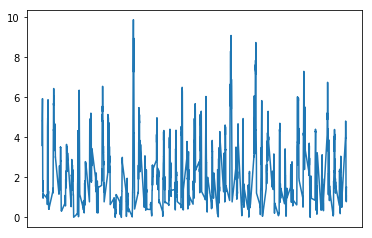

In [31]:
plt.xticks( first['MIROC5'], first.index.values ) # location, labels
plt.plot( first['MIROC5'] )
plt.show()

In [33]:
x1 = list(first['ACCESS1-0'])
x2 = list(first['CNRM-CM5'])
x3 = first.CanESM2
x4 = first['HadGEM2-ES']
x5 = first.MIROC5
x6 = list(second['ACCESS1-0'])
x7 = list(second['CNRM-CM5'])
x8 = second.CanESM2
x9 = second['HadGEM2-ES']
x10 = second.MIROC5
x11 = list(third['ACCESS1-0'])
x12 = list(third['CNRM-CM5'])
x13 = third.CanESM2
x14 = third['HadGEM2-ES']
x15 = third.MIROC5

In [34]:
# '#E69F00', 'ACCESS1-0', 
colors = ['#56B4E9', '#F0E442', '#009E73', '#D55E00']
names = ['CNRM-CM5', 'CanESM2',
         'HadGEM2-ES', 'MIROC5']

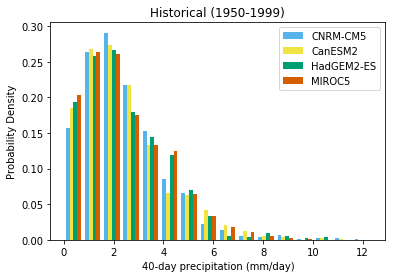

In [35]:
# x1,
plt.hist([ x2, x3, x4, x5], bins = int(250/15), normed=True,
         color = colors, label=names)
plt.legend()
plt.xlabel('40-day precipitation (mm/day)')
plt.ylabel('Probability Density')
plt.title('Historical (1950-1999)')
plt.figure(figsize=(3,4))
#plt.show()

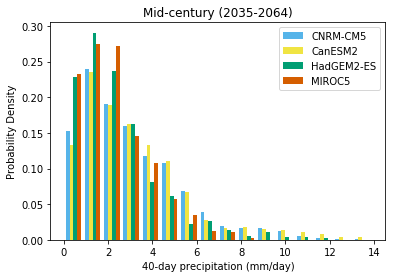

In [36]:
plt.hist([ x7, x8, x9, x10], bins = int(250/15), normed=True,
         color = colors, label=names)
plt.legend()
plt.xlabel('40-day precipitation (mm/day)')
plt.ylabel('Probability Density')
plt.title('Mid-century (2035-2064)')
plt.figure(figsize=(3,4))
#plt.show()

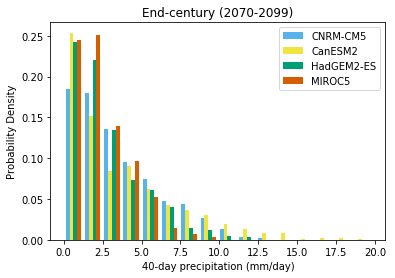

In [37]:
plt.hist([ x12, x13, x14, x15], bins = int(250/15), normed=True,
         color = colors, label=names)
plt.legend()
plt.xlabel('40-day precipitation (mm/day)')
plt.ylabel('Probability Density')
plt.title('End-century (2070-2099)')
plt.figure(figsize=(3,4))
#plt.show()

In [38]:
fit = gev.fit(third)

In [39]:
fit

(-0.32596870373569864, 1.5975751970189849, 1.3778084450081667)

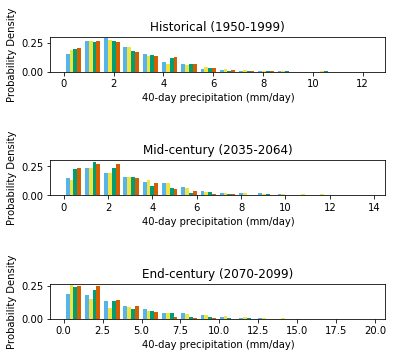

In [ ]:
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
fig = plt.figure()
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

n, bins, patches = ax1.hist([ x2, x3, x4, x5], bins = int(250/15), normed=True,
         color = colors, label=names)

n, bins, patches = ax2.hist([ x7, x8, x9, x10], bins = int(250/15), normed=True,
         color = colors, label=names)

n, bins, patches = ax3.hist([ x12, x13, x14, x15], bins = int(250/15), normed=True,
         color = colors, label=names)
ax1.set_xlabel('40-day precipitation (mm/day)')
ax1.set_ylabel('Probability Density')
ax1.set_title('Historical (1950-1999)')


ax2.set_xlabel('40-day precipitation (mm/day)')
ax2.set_ylabel('Probability Density')
ax2.set_title('Mid-century (2035-2064)')

ax3.set_xlabel('40-day precipitation (mm/day)')
ax3.set_ylabel('Probability Density')
ax3.set_title('End-century (2070-2099)')
#fig.tight_layout()
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=2.5, wspace=0.4)
#f, axs = plt.subplots(3,3,3,figsize=(15,15))
#f, axs = plt.subplots(2,2,figsize=(15,15))